In [162]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
%matplotlib inline

## Data Retreival/Formatting

In [163]:
# Pull data

btc_df = yf.download('BTC-USD', start='2021-09-01',interval='1h')[['Open','High','Low','Volume','Close']]
btc_df.index.name = 'timestamp'

btc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
timestamp,,,,,
2021-09-01 00:00:00+00:00,47005.863281,47294.664062,46788.101562,0,46788.101562
2021-09-01 01:00:00+00:00,46754.980469,46882.425781,46562.437500,549335040,46857.597656
2021-09-01 02:00:00+00:00,46873.109375,47089.496094,46773.453125,417816576,46920.796875
2021-09-01 03:00:00+00:00,46879.375000,46960.765625,46733.917969,271110144,46938.312500
2021-09-01 04:00:00+00:00,47041.230469,47246.312500,47017.937500,63414272,47158.402344
...,...,...,...,...,...
2022-10-10 01:00:00+00:00,19490.695312,19515.466797,19484.593750,275807232,19512.427734
2022-10-10 02:00:00+00:00,19510.287109,19510.287109,19471.191406,169682944,19473.847656
2022-10-10 03:00:00+00:00,19473.154297,19480.046875,19442.093750,114716672,19452.519531


In [164]:
btc_df.dtypes

Open      float64
High      float64
Low       float64
Volume      int64
Close     float64
dtype: object

In [165]:
# Shift X data to predict price 24 hours in the future
btc_df[['Open', 'High','Low','Volume','Close']]=btc_df[['Open', 'High','Low','Volume','Close']].shift(24)
display(btc_df.head())

# Drop rows w/ empty values
btc_df = btc_df.dropna()
display(btc_df.head())

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_3172\3511638838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df[['Open', 'High','Low','Volume','Close']]=btc_df[['Open', 'High','Low','Volume','Close']].shift(24)


,Open,High,Low,Volume,Close
timestamp,,,,,
2021-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2021-09-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2021-09-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2021-09-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2021-09-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN


,Open,High,Low,Volume,Close
timestamp,,,,,
2021-09-02 01:00:00+00:00,47005.863281,47294.664062,46788.101562,0.0,46788.101562
2021-09-02 02:00:00+00:00,46754.980469,46882.425781,46562.437500,549335040.0,46857.597656
2021-09-02 03:00:00+00:00,46873.109375,47089.496094,46773.453125,417816576.0,46920.796875
2021-09-02 04:00:00+00:00,46879.375000,46960.765625,46733.917969,271110144.0,46938.312500
2021-09-02 05:00:00+00:00,47041.230469,47246.312500,47017.937500,63414272.0,47158.402344


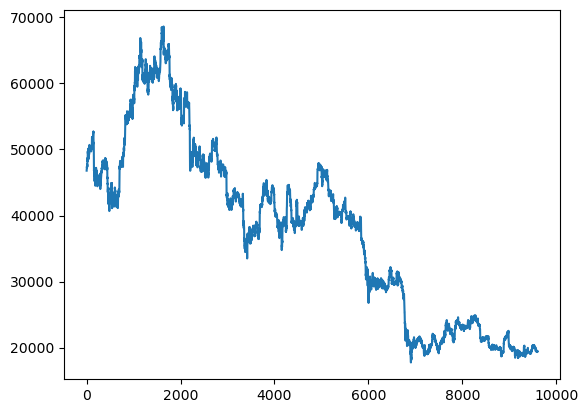

In [166]:
plt.plot(range(len(btc_df)), btc_df[['Close']])

### Splitting data into 3D Tensors

In [167]:
# Split test and train data

split_ratio=.7
train_count=int(len(btc_df)*.7)

train=btc_df.iloc[:train_count]
test=btc_df.iloc[train_count:]

In [168]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to the features training dataset
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.48420449, 0.47977872, 0.48516987, 0.        , 0.47842622],
       [0.47821475, 0.46980173, 0.47981282, 0.00220604, 0.48008631],
       [0.48103503, 0.47481325, 0.48482213, 0.00167788, 0.48159598],
       ...,
       [0.05998182, 0.04287452, 0.06764893, 0.        , 0.05844709],
       [0.05926749, 0.04366473, 0.06754461, 0.        , 0.05993437],
       [0.06073098, 0.04400857, 0.06873022, 0.        , 0.05989742]])

In [169]:
# Scale test data
test_scaled = scaler.fit_transform(test)

test_scaled

array([[0.9917544 , 0.99660292, 0.99625549, 0.        , 1.        ],
       [1.        , 1.        , 0.99880977, 0.01470376, 0.99365561],
       [0.99350099, 0.99151577, 0.99808012, 0.        , 0.99437543],
       ...,
       [0.13436142, 0.11496549, 0.14143968, 0.        , 0.1394895 ],
       [0.13346179, 0.11404914, 0.14108615, 0.        , 0.1406901 ],
       [0.13433788, 0.11719015, 0.14382756, 0.        , 0.14368957]])

In [170]:
# Set global candles variable
candles=60

# Create X training set
X_train = []

for i in range(len(train_scaled) - candles):
    X_train.append(train_scaled[:,:4][i:i+candles])

X_train = np.array(X_train)
X_train.shape

(6662, 60, 4)

In [171]:
# Create y training set
y_train = []

for i in range(len(train_scaled) - candles):
    y_train.append(train_scaled[:,(4)][i+candles])

y_train = np.array(y_train)
y_train.shape

(6662,)

In [172]:
# Create X test set
X_test = []

for i in range(len(test_scaled) - candles):
    X_test.append(test_scaled[:,:4][i  : i+candles])

X_test = np.array(X_test)
X_test.shape

(2822, 60, 4)

In [173]:
# Create y test set
y_test = []

for i in range(len(test_scaled) - candles):
    y_test.append(test_scaled[:,(4)][i+candles])

y_test = np.array(y_test)
y_test.shape

(2822,)

## Model Creation

In [174]:
# Create the Sequential model instance
regr_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = 64
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

64

64

64

In [175]:
# Add the first hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_shape=(candles,(len(btc_df.columns)-1))))

In [176]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [177]:
#Add the second hidden layer
regr_nn.add(LSTM(units=hidden_nodes, return_sequences=True))


In [178]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [179]:
# #Add the third hidden layer
regr_nn.add(LSTM(units=hidden_nodes))

In [180]:
# # Add dropout layer
# regr_nn.add(Dropout(rate=0.2))

In [181]:
# Add Dense layer
# regr_nn.add(Dense(units=6, activation='relu'))

In [182]:
# Add the output layer to the model specifying the number of output neurons and activation function
regr_nn.add(Dense(units=1,  activation='linear'))


In [183]:
# Display the Sequential model summary, subclassed model requires build
regr_nn.build(X_train.shape)
regr_nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 64)            17664     
                                                                 
 dropout_10 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_11 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,777
Trainable params: 83,777
Non-trai

In [184]:
# Compile the Sequential model

regr_nn.compile(loss='mean_squared_error', optimizer='adam')

In [185]:
# Fit the model using epochs and the training data
regr_model=regr_nn.fit(X_train, y_train, epochs=20, validation_split=.01)

Epoch 1/20
207/207 [==============================] - 10s 26ms/step - loss: 0.0043 - val_loss: 4.3409e-05
Epoch 2/20
207/207 [==============================] - 4s 19ms/step - loss: 8.2414e-04 - val_loss: 3.7988e-05
Epoch 3/20
207/207 [==============================] - 4s 19ms/step - loss: 7.1696e-04 - val_loss: 1.7153e-04
Epoch 4/20
207/207 [==============================] - 4s 19ms/step - loss: 6.7965e-04 - val_loss: 3.5072e-05
Epoch 5/20
207/207 [==============================] - 4s 20ms/step - loss: 6.0484e-04 - val_loss: 5.2376e-05
Epoch 6/20
207/207 [==============================] - 4s 19ms/step - loss: 5.2662e-04 - val_loss: 1.3560e-04
Epoch 7/20
207/207 [==============================] - 4s 19ms/step - loss: 5.5765e-04 - val_loss: 7.3637e-05
Epoch 8/20
207/207 [==============================] - 4s 21ms/step - loss: 4.6719e-04 - val_loss: 7.9893e-05
Epoch 9/20
207/207 [==============================] - 5s 24ms/step - loss: 4.7453e-04 - val_loss: 1.1376e-04
Epoch 10/20
207/207 [=

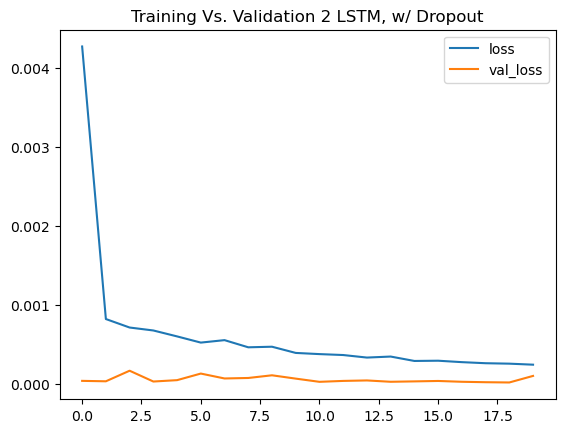

In [186]:
# Train vs test for loss
plt.plot(regr_model.history["loss"])
plt.plot(regr_model.history["val_loss"])
plt.title("Training Vs. Validation 2 LSTM, w/ Dropout")
plt.legend(["loss", "val_loss"])
plt.show()

In [187]:
# Make model predictionis

y_pred=regr_nn.predict(X_test)

y_pred


89/89 [==============================] - 2s 10ms/step


array([[0.4896343 ],
       [0.4821195 ],
       [0.48157564],
       ...,
       [0.13913655],
       [0.13972637],
       [0.13996649]], dtype=float32)

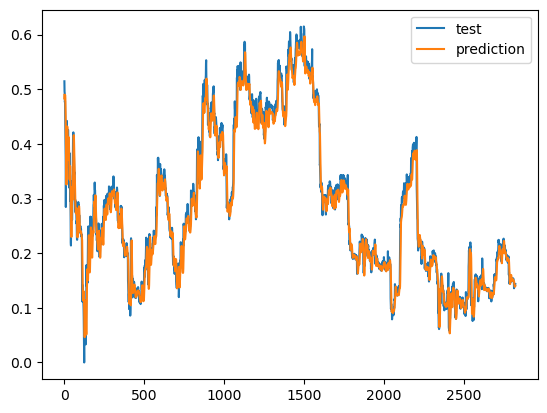

In [188]:
# Plot prediction results
plt.plot(range(len(y_test)), (y_test))
plt.plot(range(len(y_test)), (y_pred))
plt.legend(["test", "prediction"])

In [189]:
# Set the file path for the first regression model
file_path = Path('Models/regr_nn.h5')

# Export your model to a HDF5 file
regr_nn.save(file_path)